# Сборный проект - 2

**Описание проекта**  
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён

**Задачи проекта:**
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании

## Описание данных для 1-ой задачи

* Тренировочная выборка: train_job_satisfaction_rate.csv

* Входные признаки тестовой выборки: test_features.csv

* Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv

**Признаки исходных данных:**

*id* — уникальный идентификатор сотрудника;

*dept* — отдел, в котором работает сотрудник;

*level* — уровень занимаемой должности;

*workload* — уровень загруженности сотрудника;

*employment_years* — длительность работы в компании (в годах);

*last_year_promo* — показывает, было ли повышение за последний год;

*last_year_violations* — показывает, нарушал ли сотрудник трудовой договор за последний год;

*supervisor_evaluation* — оценка качества работы сотрудника, которую дал руководитель;

*salary* — ежемесячная зарплата сотрудника;

*job_satisfaction_rate* — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Описание данных для 2-ой задачи

* Тренировочная выборка: train_quit.csv

* Входные признаки тестовой выборки (как для 1-ой задачи): test_features.csv

* Целевой признак тестовой выборки: test_target_quit.csv

**Признаки исходных данных:**

*quit* — увольнение сотрудника из компании.

## Задача 1. Предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [39]:
!pip install phik
!pip install -Uq scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik

from phik.report import plot_correlation_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier


In [40]:
pd.set_option('display.max_colwidth', None)

In [41]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [42]:
X_test = pd.read_csv('/datasets/test_features.csv')
X_test.info()
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [43]:
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
y_test.info()
y_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Данные во всех таблицах соответствуют описанию

### Предобработка данных

In [44]:
#пайплайн для заполнения пропусков
#imputer_pipe = Pipeline(
#    [
#        (
#            'simplerImputer',
#            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#       )
#   ]
#)

#### Тренировочная выборка (train)

In [45]:
#вывод уникальных значений категориальных признаков
for col in train.select_dtypes('object').columns:
    print(f'{col}: {train[col].unique()}')

dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'high' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


Есть пропуски в столбцах dept и level. Также обнаружена орфографическая ошибка в слове senior.

In [46]:
train['level'] = train['level'].replace('sinior', 'senior')
train['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [47]:
train[train['dept'].isna() | train['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Строк с пропусками всего 10 - заполним с помощью пайплайна.

In [48]:
#nan_cols = ['dept', 'level', 'workload']
#train[nan_cols] = imputer_pipe.fit_transform(train[nan_cols])
#train.isna().sum()

In [49]:
train.duplicated().sum()

0

#### Входные признаки тестовой выборки (X_test)

In [50]:
#вывод уникальных значений категориальных признаков
for col in X_test.select_dtypes('object').columns:
    print(f'{col}: {X_test[col].unique()}')

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'low' 'high' ' ']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


Есть пропуски в столбцах dept, level, а также символ пробела в столбцах dept, workload и все та же орфографическая ошибка.

In [51]:
X_test['level'] = X_test['level'].replace('sinior', 'senior')
X_test['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [52]:
#заменим пробел на пропуск и выведем строки с пропусками на экран
#X_test['dept'] = X_test['dept'].replace(' ', np.nan)
#X_test['workload'] = X_test['workload'].replace(' ', np.nan)
#X_test[X_test['dept'].isna() | X_test['level'].isna() | X_test['workload'].isna()]

Строк с пропусками получилось 5 - заполним с помощью пайплайна.

In [53]:
#X_test[nan_cols] = imputer_pipe.transform(X_test[nan_cols])
#X_test.isna().sum()

In [54]:
X_test.duplicated().sum()

0

**Вывод:** на этапе предобработки данных были обнаружены и обработаны пропуски и некорректные значения в строках, так же устранены орфографические ошибки. Дубликаты не обнаружены, типы данных и названия столбцов в норме.

### Исследовательский анализ данных

#### Количественные признаки (train)

In [55]:
train.drop('id', axis=1).describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


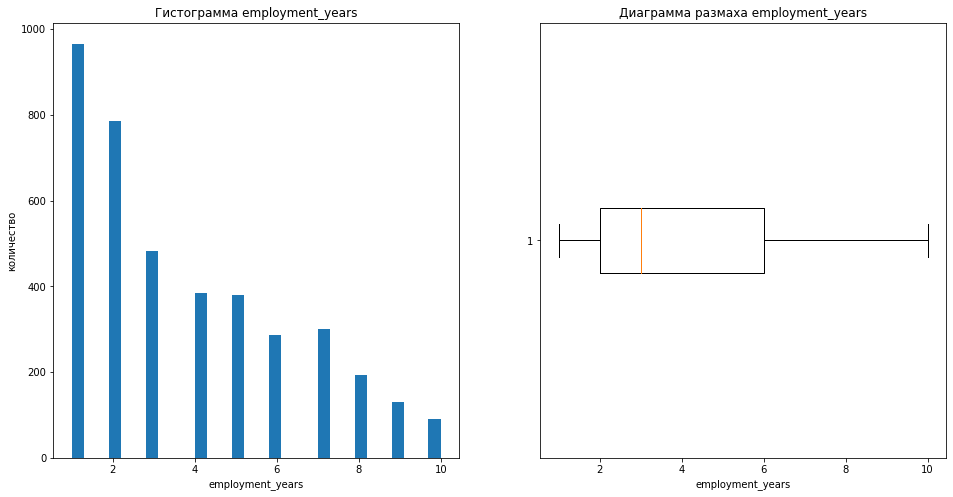

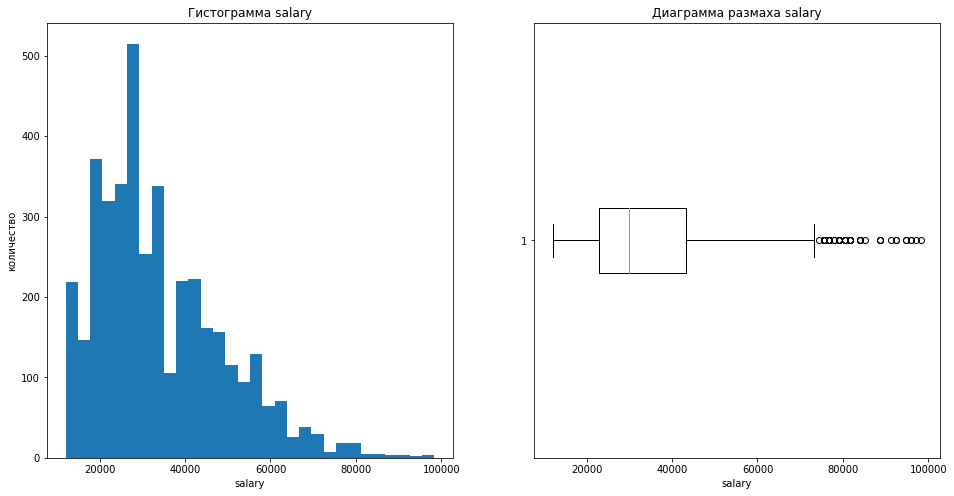

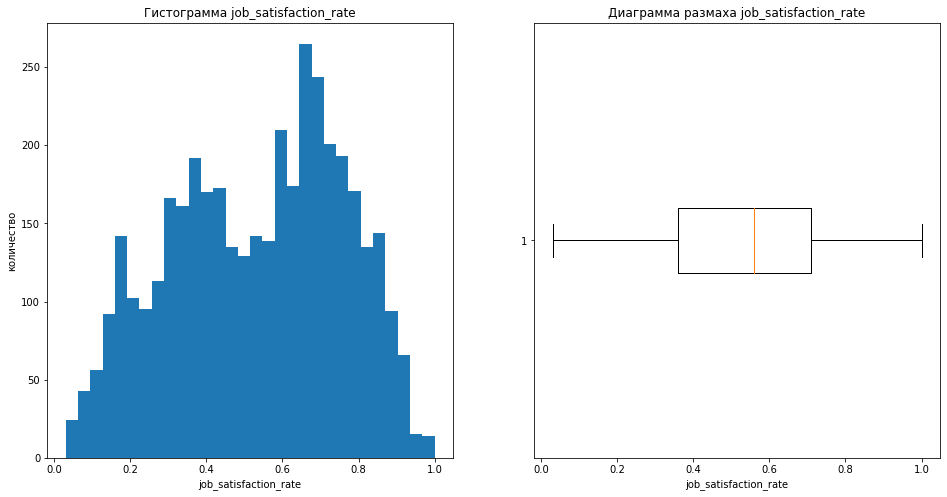

In [56]:
for col in train.select_dtypes(exclude='object').drop(['id', 'supervisor_evaluation'], axis=1).columns:
    fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
    ax[0].hist(data=train, x=col, bins=30)
    ax[0].set_title(f'Гистограмма {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('количество')
    ax[1].boxplot(data=train, x=col, vert=False)
    ax[1].set_title(f'Диаграмма размаха {col}')
    ax[1].set_xlabel(col)
    plt.show()

#### Категориальные признаки (train)

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

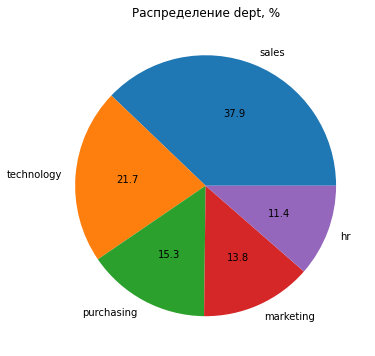

junior    1894
middle    1744
senior     358
Name: level, dtype: int64

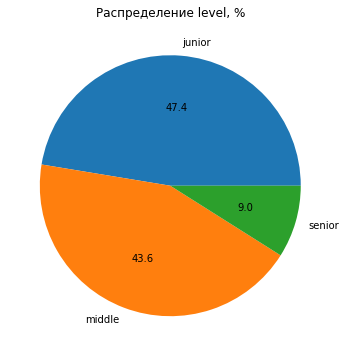

medium    2066
low       1200
high       734
Name: workload, dtype: int64

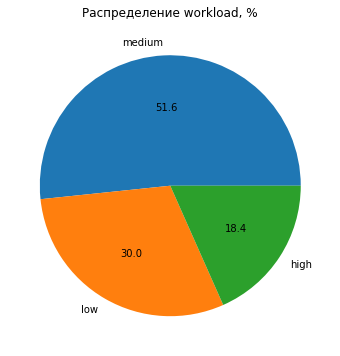

no     3880
yes     120
Name: last_year_promo, dtype: int64

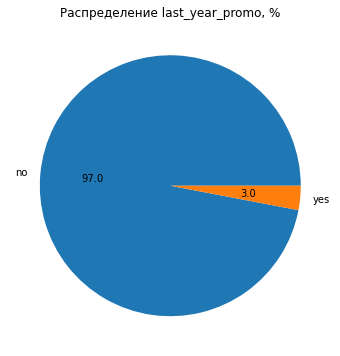

no     3441
yes     559
Name: last_year_violations, dtype: int64

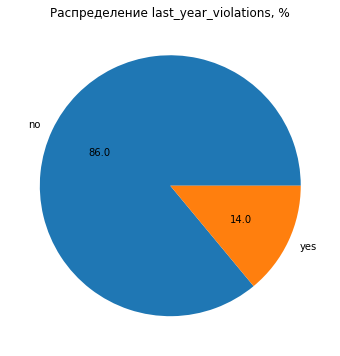

4    1603
3    1263
5     546
2     387
1     201
Name: supervisor_evaluation, dtype: int64

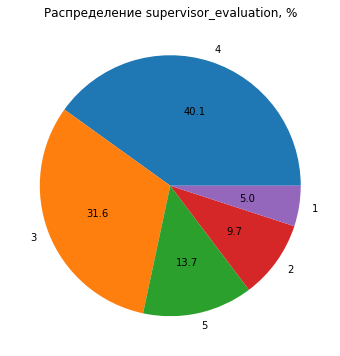

In [57]:
cat_col = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
for col in train[cat_col]:
    display(train[col].value_counts())
    train[col].value_counts().plot(kind='pie', title=f'Распределение {col}, %', autopct='%.1f', figsize=(10, 6))
    plt.ylabel(None)
    plt.show()

#### Количественные признаки (X_test)

In [58]:
X_test.drop('id', axis=1).describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


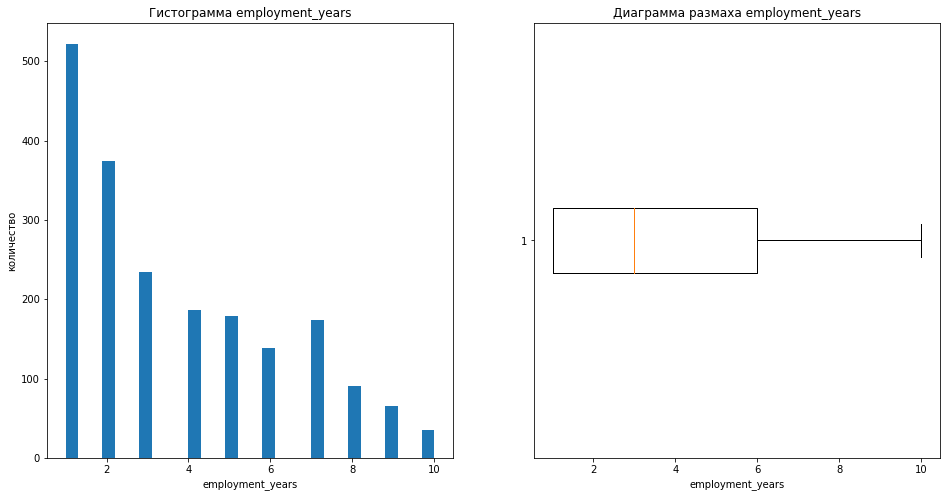

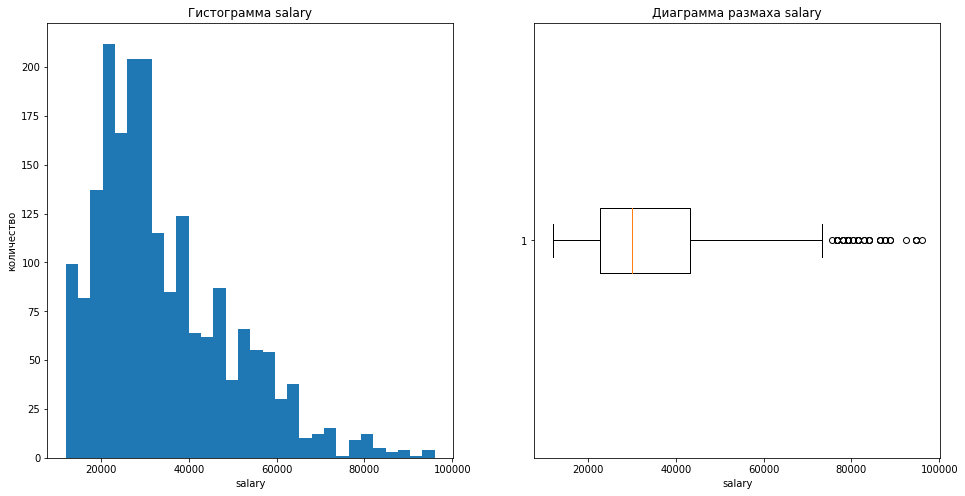

In [59]:
for col in X_test.select_dtypes(exclude='object').drop(['id', 'supervisor_evaluation'], axis=1).columns:
    fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
    ax[0].hist(data=X_test, x=col, bins=30)
    ax[0].set_title(f'Гистограмма {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('количество')
    ax[1].boxplot(data=X_test, x=col, vert=False)
    ax[1].set_title(f'Диаграмма размаха {col}')
    ax[1].set_xlabel(col)
    plt.show()

#### Категориальные признаки (X_test)

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

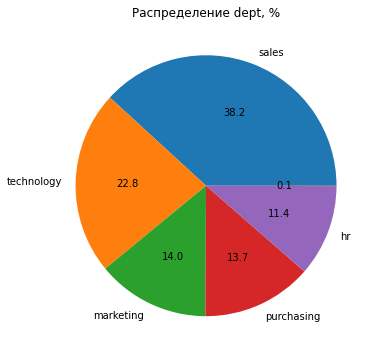

junior    974
middle    854
senior    171
Name: level, dtype: int64

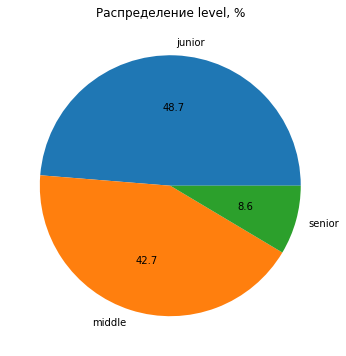

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

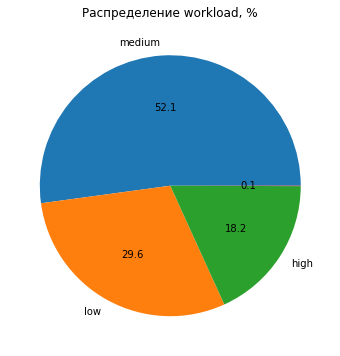

no     1937
yes      63
Name: last_year_promo, dtype: int64

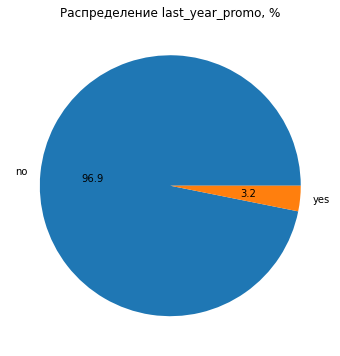

no     1738
yes     262
Name: last_year_violations, dtype: int64

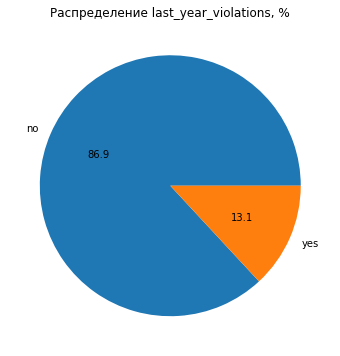

4    857
3    575
5    284
2    196
1     88
Name: supervisor_evaluation, dtype: int64

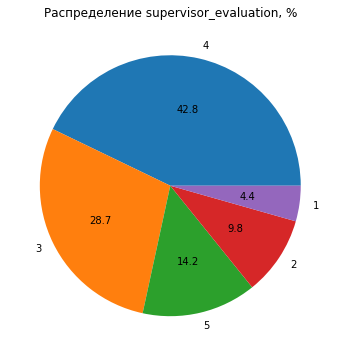

In [60]:
for col in X_test[cat_col]:
    display(X_test[col].value_counts())
    X_test[col].value_counts().plot(kind='pie', title=f'Распределение {col}, %', autopct='%.1f', figsize=(10, 6))
    plt.ylabel(None)
    plt.show()

#### Корреляционный анализ

In [61]:
phik_overview = train.drop('id', axis=1).phik_matrix()

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


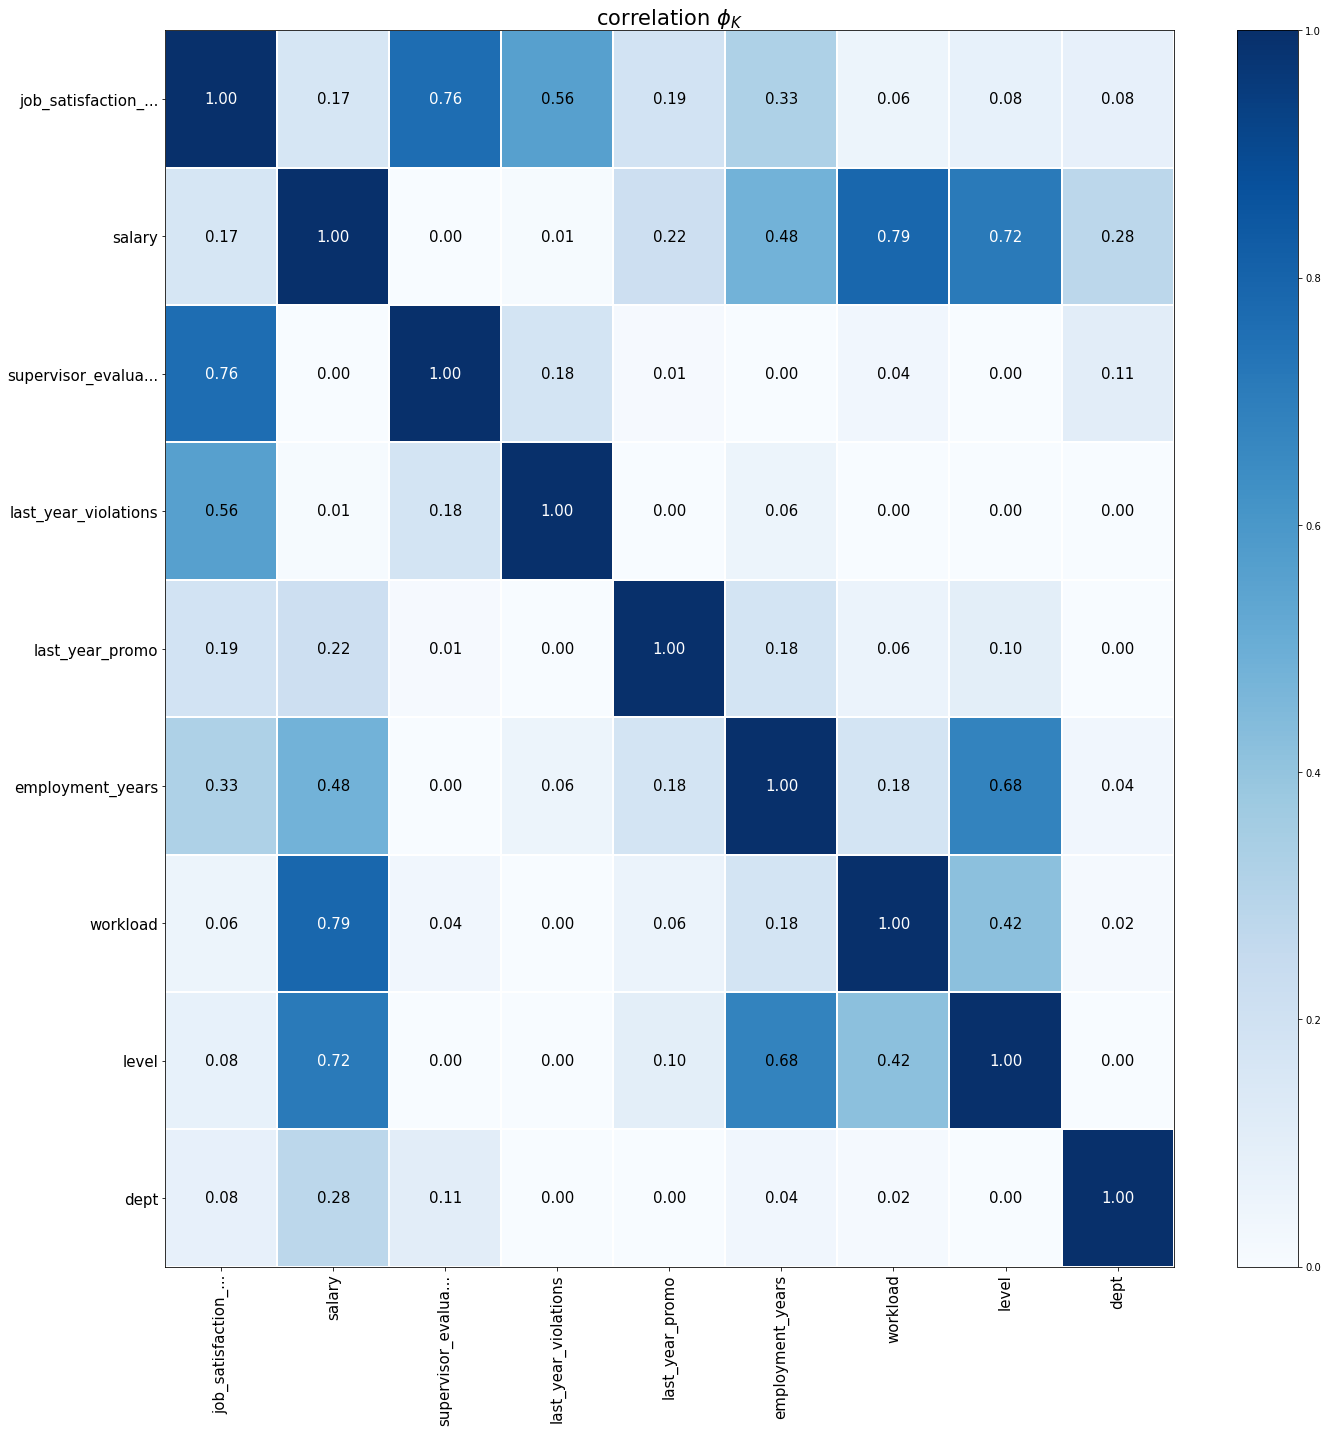

In [62]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20, 20))

**Вывод:** на этапе исследовательского анализа построены гистограммы распределения и диаграммы размаха для количественных признаков, круговые диаграммы для категориальных признаков. Построена матрица корреляций признаков.
* На диаграмме размаха зарплаты видны выбросы, их немного, поэтому убирать их не будем
* Распределение целевого признака похоже на нормальное, но с двумя пиковыми значениями
* Есть дисбаланс классов у признаков last_year_promo и last_year_violations
* Для признаков level, workload будем импользовать OrdinalEncoder, для остальных категориальных признаков OneHotEncoder
* Целевой признак имеет среднюю и высокую корреляции с признаками last_year_violations (0.56) и supervisor_evaluation (0.76), утечки целевого признака не обнаружено

### Подготовка данных

In [63]:
train_ml = train.set_index('id')

train_ml.duplicated().sum()

245

После замены столбца id на индекс датафрейма появились дубликаты - удаляем их

In [ ]:
train_ml = train_ml.drop_duplicates()
train_ml.duplicated().sum()

0

In [65]:
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
ord_cols = ['level', 'workload']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary']

RANDOM_STATE = 42

X_train = train_ml.drop('job_satisfaction_rate', axis=1)
y_train = train_ml['job_satisfaction_rate']

#### Создание пайплайнов

In [66]:
#пайплайн для подготовки признаков из списка ohe_cols
ohe_pipe = Pipeline(
    [
        (
            'simplerImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
#            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [67]:
#пайплайн для подготовки признаков из списка ord_cols
ord_pipe = Pipeline(
    [
        (
            'simplerImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
#               handle_unknown='error'
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simplerImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [68]:
#общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [69]:
#итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

#### Создание метрики

Для оценки качества моделей создадим метрику SMAPE - симметричное среднее абсолютное процентное отклонение

In [70]:
def smape(y_true, y_pred):
    exp = (100 / len(y_true)) * np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
    return exp

smape_score = make_scorer(smape, greater_is_better=False)

### Обучение моделей

In [71]:
#список словарей для подбора параметров моделей
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_leaf': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

In [72]:
#подбор гиперпараметров
rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=10,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simplerImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               P...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 20),
                                         'models__min_samples_leaf': range(2, 20),
                                         'models__min_samples_split': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [73]:
best_model = rs.best_estimator_
print(f'Лучшая модель:\n{best_model}\n')
print(f'Метрика SHAPE лучшей модели: {rs.best_score_}')

Лучшая модель:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simplerImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                            

In [74]:
result = pd.DataFrame(rs.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
0,1,DecisionTreeRegressor(random_state=42),-15.432515,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 18, 'models__min_samples_leaf': 5, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
4,2,DecisionTreeRegressor(random_state=42),-15.618342,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 9, 'models__min_samples_leaf': 9, 'models__max_depth': 19, 'models': DecisionTreeRegressor(random_state=42)}"
3,3,DecisionTreeRegressor(random_state=42),-16.072372,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}"
2,4,DecisionTreeRegressor(random_state=42),-16.135959,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 14, 'models__min_samples_leaf': 7, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}"
6,5,DecisionTreeRegressor(random_state=42),-16.312614,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 19, 'models__min_samples_leaf': 13, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"


Лучшая модель DecisionTreeRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=18) показала значение метрики SMAPE на тренировочной выборке 15.5

In [75]:
X_test_ml = X_test.set_index('id').sort_index()
y_test_ml = y_test.set_index('id').sort_index()
X_test_ml.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [76]:
pred = best_model.predict(X_test_ml)
smape_test = smape(y_test_ml['job_satisfaction_rate'], pred)
print(f'Метрика SMAPE на тестовой выборке: {round(smape_test, 1)}')

Метрика SMAPE на тестовой выборке: 13.8


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Значение меньше 15, значит модель работает успешно

### Вывод к задаче 1

На данном этапе работы была создана модель, которая предсказывает уровень удовлетворённости сотрудника.
* Лучшая модель и ее гиперпараметры: DecisionTreeRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=18)
* Значения метрики SMAPE на тестовой выборке составляет 13.8, что весьма неплохо
* DecisionTreeRegressor справилась с задачей лучше LinearRegression, так как она способна обрабатывать нелинейные зависимости

## Задача 2. Предсказание увольнения сотрудника

### Загрузка данных

In [39]:
train_2 = pd.read_csv('/datasets/train_quit.csv')
train_2.info()
train_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [40]:
test_2 = pd.read_csv('/datasets/test_target_quit.csv')
test_2.info()
test_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные во всех таблицах соответствуют описанию

### Предобработка данных

#### Тренировочная выборка (train_2)

In [41]:
for col in train_2.select_dtypes('object').columns:
    print(f'{col}: {train_2[col].unique()}')

dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level: ['middle' 'junior' 'sinior']
workload: ['high' 'medium' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
quit: ['no' 'yes']


Исправляем орфографическую ошибку

In [42]:
train_2['level'] = train['level'].replace('sinior', 'senior')
train_2['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [43]:
train_2.duplicated().sum()

0

#### Входные признаки тестовой выборки (X_test)

In [44]:
X_test.info()
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


#### Целевой признак тестовой выборки (test_2)

In [45]:
test_2['quit'].unique()

array(['yes', 'no'], dtype=object)

**Вывод:** на этапе предобработки данных была устранена орфографическая ошибка. Дубликаты не обнаружены, типы данных и названия столбцов в норме.

### Исследовательский анализ данных

#### Количественные признаки (train_2)

In [46]:
train_2.drop('id', axis=1).describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


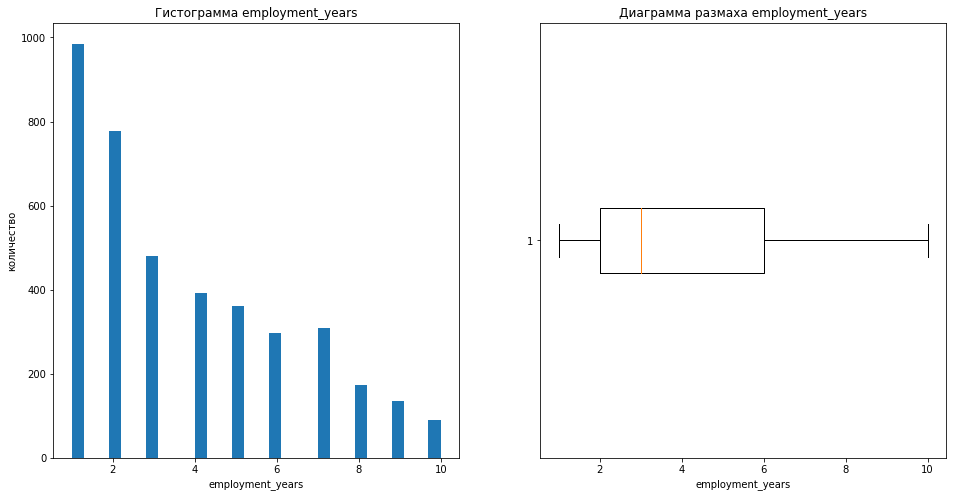

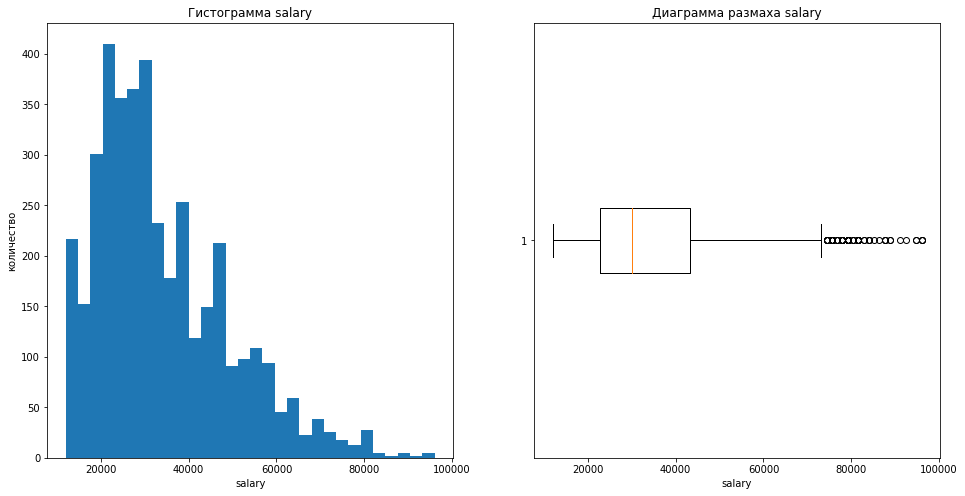

In [47]:
for col in train_2.select_dtypes(exclude='object').drop(['id', 'supervisor_evaluation'], axis=1).columns:
    fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
    ax[0].hist(data=train_2, x=col, bins=30)
    ax[0].set_title(f'Гистограмма {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('количество')
    ax[1].boxplot(data=train_2, x=col, vert=False)
    ax[1].set_title(f'Диаграмма размаха {col}')
    ax[1].set_xlabel(col)
    plt.show()

#### Категориальные признаки (train_2)

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

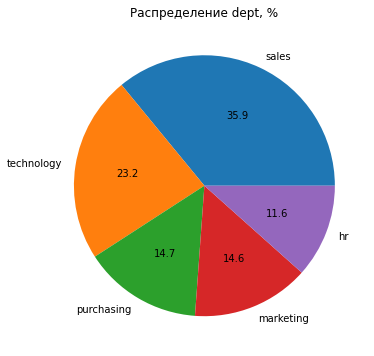

junior    1894
middle    1744
senior     358
Name: level, dtype: int64

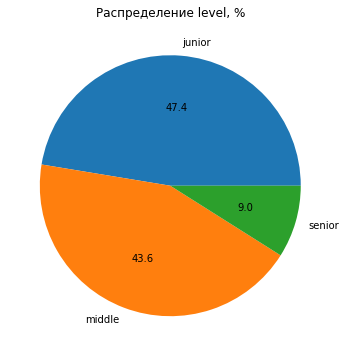

medium    2118
low       1208
high       674
Name: workload, dtype: int64

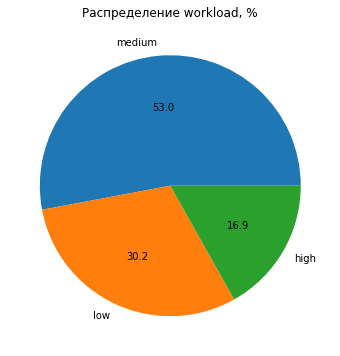

no     3887
yes     113
Name: last_year_promo, dtype: int64

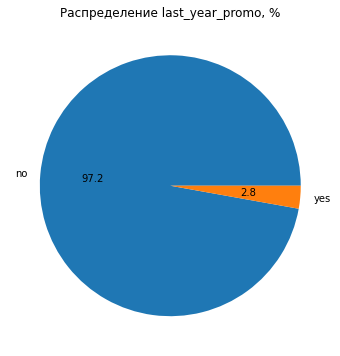

no     3455
yes     545
Name: last_year_violations, dtype: int64

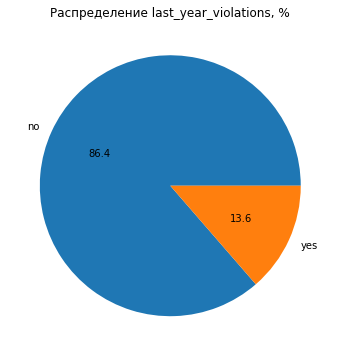

4    1654
3    1233
5     520
2     391
1     202
Name: supervisor_evaluation, dtype: int64

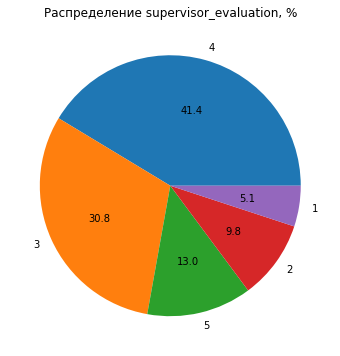

no     2872
yes    1128
Name: quit, dtype: int64

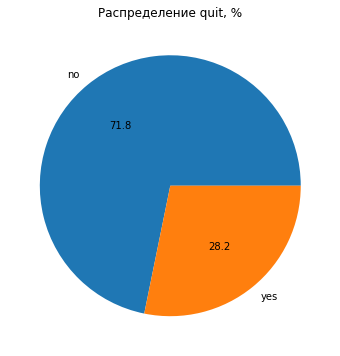

In [48]:
cat_col_2 = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'quit']
for col in train_2[cat_col_2]:
    display(train_2[col].value_counts())
    train_2[col].value_counts().plot(kind='pie', title=f'Распределение {col}, %', autopct='%.1f', figsize=(10, 6))
    plt.ylabel(None)
    plt.show()

#### Корреляционный анализ

In [49]:
phik_overview_2 = train_2.drop('id', axis=1).phik_matrix()

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


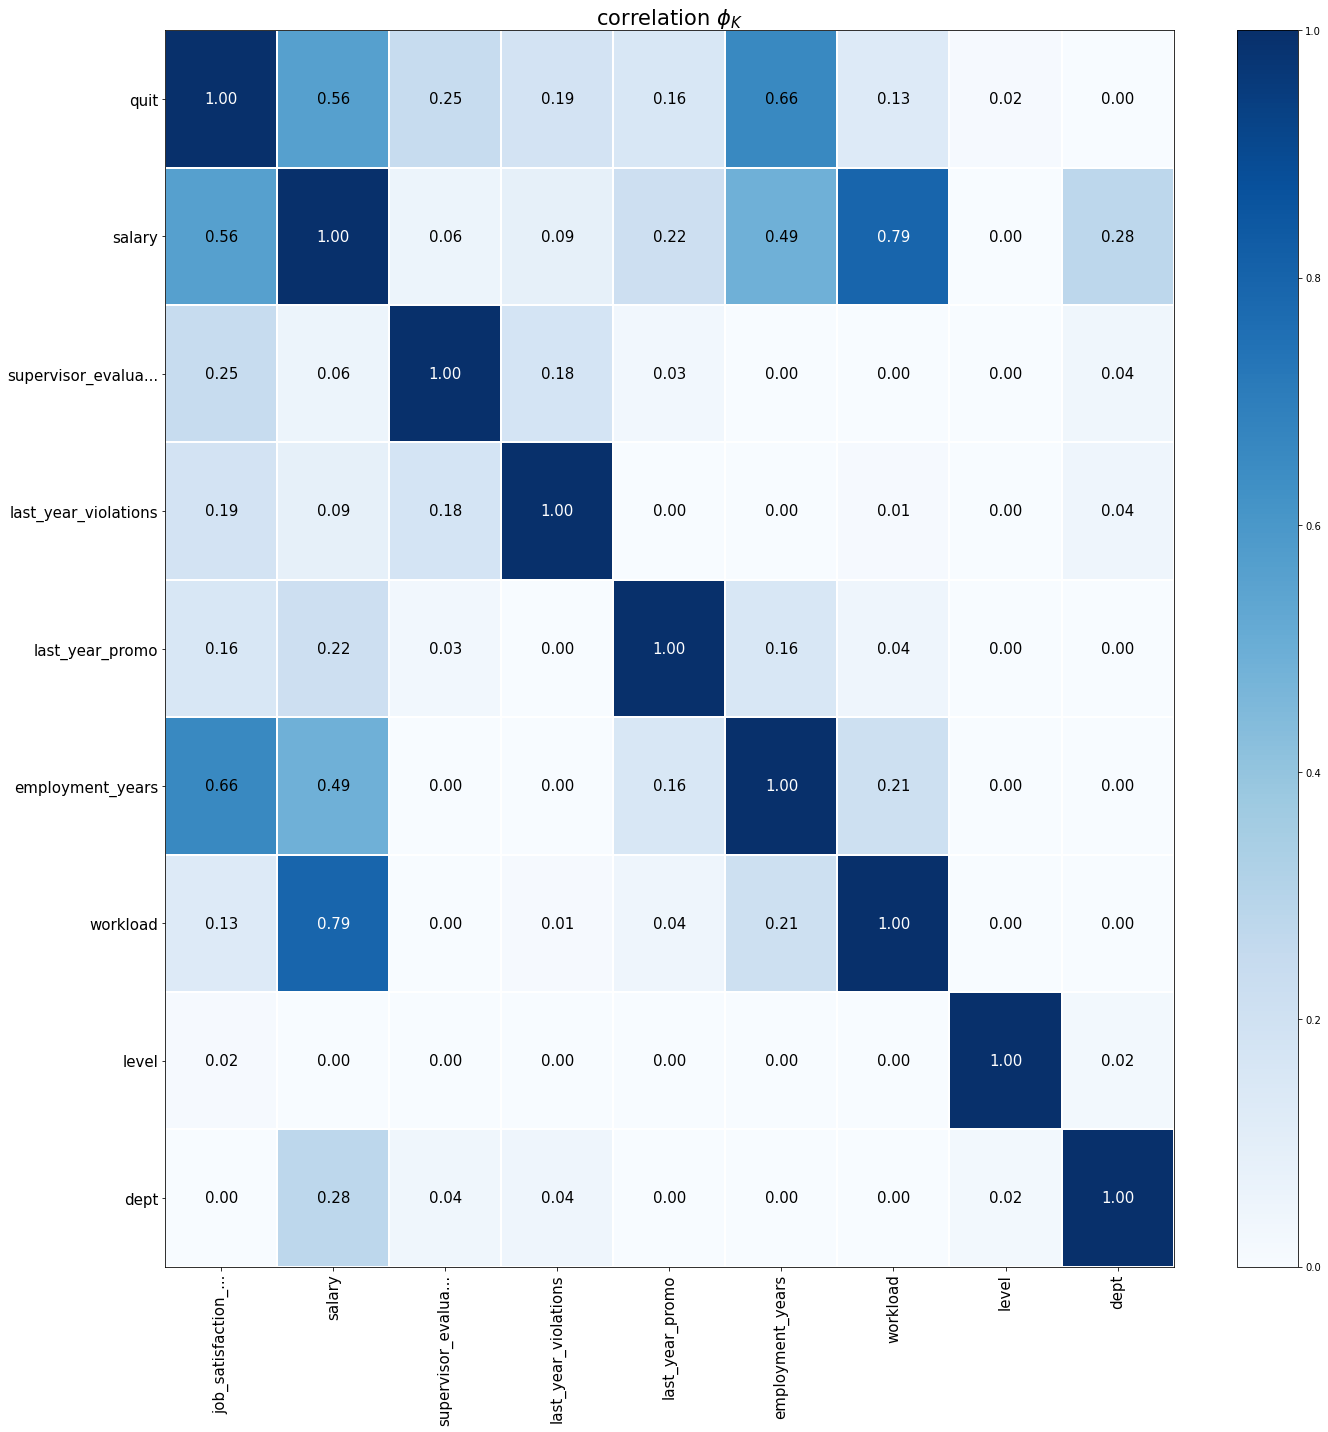

In [50]:
plot_correlation_matrix(phik_overview_2.values, x_labels=phik_overview.columns, y_labels=phik_overview_2.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20, 20))

#### Портрет «уволившегося сотрудника»

In [51]:
train_2.pivot_table(index='quit', columns='level', values='salary', aggfunc='median').T #медианная зарплата в зависимости от должности

quit,no,yes
level,,
junior,34800,22800
middle,34800,22800
senior,34800,21600


In [52]:
portrait = train_2.pivot_table(index='quit', columns='dept', values='salary', aggfunc='count').T
portrait['ratio'] = round(portrait['no'] / portrait['yes'], 1)
portrait #оставшиеся/уволившиеся сотрудники разибтые по отделам

quit,no,yes,ratio
dept,,,
hr,348,116,3.0
marketing,419,163,2.6
purchasing,422,166,2.5
sales,1031,407,2.5
technology,652,276,2.4


In [53]:
train_2.pivot_table(index='quit', columns='workload', values='salary', aggfunc='count').T #оставшиеся/уволившиеся сотрудники в зависимости от загрузки

quit,no,yes
workload,,
high,553,121
low,689,519
medium,1630,488


In [54]:
train_2.pivot_table(index='quit', columns='level', values='salary', aggfunc='count').T #оставшиеся/уволившиеся сотрудники в зависимости от должности

quit,no,yes
level,,
junior,1367,527
middle,1230,514
senior,272,86


In [55]:
train_2.pivot_table(index='quit', columns='dept', values='employment_years').T #оставшиеся/уволившиеся сотрудники средняя продолжительность работы в компании по отделам

quit,no,yes
dept,,
hr,4.390805,1.758621
marketing,4.470167,1.858896
purchasing,4.386256,1.957831
sales,4.514064,1.859951
technology,4.323620,1.782609


Портрет уволившегося сотрудника:
* в среднем зарабатывает 22800 (на 34.5% меньше остальных сотрудников)
* имеет низкую/среднюю загрузку
* имеет уровень junior/middle
* вероятнее всего из отделов sales или technology
* в среднем проработал 1,5-2 года

#### Оценка влияния уровеня удовлетворённости сотрудника работой в компании на его увольнение

In [56]:
eval_test = y_test.merge(test_2, on='id') #объединяем признаки в одну таблицу
eval_test.info()
eval_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
 2   quit                   2000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 62.5+ KB


,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


In [57]:
eval_test.groupby('quit')['id'].count() #кол-во неуволившихся и уволившихся сотрудников

quit
no     1436
yes     564
Name: id, dtype: int64

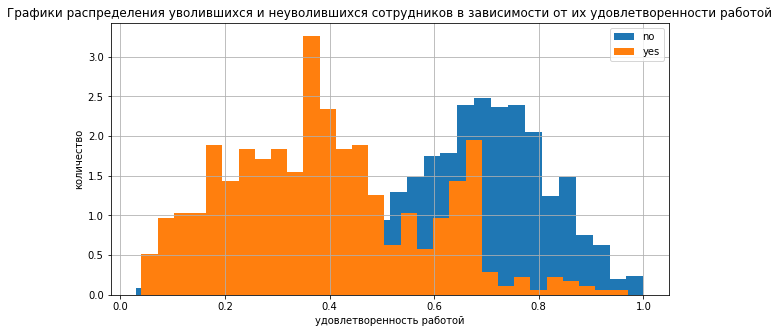

In [58]:
eval_test.groupby('quit')['job_satisfaction_rate'].hist(bins=30, figsize=(10, 5), legend=True, density=True)
plt.title('Графики распределения уволившихся и неуволившихся сотрудников в зависимости от их удовлетворенности работой')
plt.xlabel('удовлетворенность работой')
plt.ylabel('количество')
plt.show()

In [59]:
eval_test.groupby('quit')['job_satisfaction_rate'].mean() #средние значения удовлетворенности по группам

quit
no     0.612040
yes    0.387713
Name: job_satisfaction_rate, dtype: float64

Утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник верно. На основе графика и полученных значений видим, что уровень удовлетворенности уволившихся сотрудников в среднем был в 1,5 раз ниже, чем у оставшихся

**Вывод:** на этапе исследовательского анализа построены гистограммы распределения и диаграммы размаха тренировочной выборки для количественных признаков, круговые диаграммы для категориальных признаков. Построена матрица корреляций признаков. Составлен портер уволившегося сотрудника и подтверждено утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на его возможное увольнение
* На диаграмме размаха зарплаты видны выбросы, их немного, поэтому убирать их не будем
* Есть дисбаланс целевого признака
* Есть дисбаланс классов у признаков last_year_promo и last_year_violations
* Для признаков level, workload будем импользовать OrdinalEncoder, для целевого признака - LabelEncoder, для остальных категориальных признаков OneHotEncoder
* Целевой признак имеет среднюю корреляцию с признаками employment_years (0.66) и salary (0.56), утечки целевого признака не обнаружено
* Сотрудники с низкой загрузкой увольняются чаще других
* Сотрудники увольняются независимо от отдела, в котором работают
* Уволившийся сотрудник в среднем зарабатывал 22800 (на 34.5% меньше остальных сотрудников)
* Уволившийся сотрудник в среднем проработал 1.5-2 года
* Уровень удовлетворенности уволившихся сотрудников в среднем был в 1.5 раза ниже, чем у оставшихся

### Добавление нового входного признака

Добавим с помощью лучшей модели задачи 1 предсказанные значения признака job_satisfaction_rate к входным признакам задачи 2

In [60]:
train_2_ml = train_2.set_index('id')
train_2_ml.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,junior,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,junior,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [61]:
pred_JSR = best_model.predict(train_2_ml.drop('quit', axis=1))
pred_JSR

array([0.79785714, 0.83136364, 0.36133333, ..., 0.42857143, 0.838     ,
       0.24      ])

In [62]:
train_2_ml_add = train_2_ml.copy(deep=True)
train_2_ml_add['job_satisfaction_rate'] = pred_JSR
train_2_ml_add.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,junior,high,2,no,no,4,54000,no,0.797857
814010,sales,junior,medium,2,no,no,4,27600,no,0.831364
155091,purchasing,junior,medium,5,no,no,1,37200,no,0.361333
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.356875
910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


Теперь добавим признак к тестовой выборке

In [63]:
X_test_2_ml_add = X_test_ml.copy(deep=True)
X_test_2_ml_add['job_satisfaction_rate'] = pred
X_test_2_ml_add.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.836522
100480,marketing,junior,low,4,no,no,4,16800,0.841667
100503,purchasing,middle,high,5,no,no,4,55200,0.738000
100610,sales,middle,medium,5,no,no,4,43200,0.824643
100692,sales,middle,high,6,no,no,4,48000,0.704000


**Вывод:** на данном этапе задачи добавили к входным данным тренировочной и тестовой выборкам новый признак job_satisfaction_rate, предсказанный лучшей моделью в задаче 1.

### Подготовка данных

У нас появился новый количественный признак, добавляем его к num_cols

In [64]:
num_cols.append('job_satisfaction_rate')

X_train_2 = train_2_ml_add.drop('quit', axis=1)
y_train_2 = train_2_ml_add['quit']

In [65]:
#X_test_ml = X_test.set_index('id').sort_index()
y_test_2_ml = test_2.set_index('id').sort_index()

y_test_2 = y_test_2_ml['quit']

In [66]:
label_encoder = LabelEncoder() #кодируем целевой признак

y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

In [67]:
#обновляем пайплайн
pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

### Обучение моделей

In [68]:
#список словарей для подбора параметров моделей
param_grid_2 = [
    {
        'models': [LogisticRegression()],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 6),
        'models__min_samples_leaf': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

In [69]:
#подбор гиперпараметров
rs = RandomizedSearchCV(
    pipe_final_2,
    param_grid_2,
    cv=10,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rs.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simplerImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               P...
                                         'models__max_depth': range(2, 20),
                                         'models__max_features': range(2, 6),
                                         'models__min_samples_leaf': range(2, 20),
                                         'models__min_samples_split': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [70]:
best_model_2 = rs.best_estimator_
print(f'Лучшая модель:\n{best_model_2}\n')
print(f'Метрика ROC-AUC лучшей модели: {rs.best_score_}')

Лучшая модель:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simplerImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                            

In [71]:
result = pd.DataFrame(rs.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
8,1,DecisionTreeClassifier(random_state=42),0.912657,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 12, 'models__min_samples_leaf': 17, 'models__max_features': 3, 'models__max_depth': 10, 'models': DecisionTreeClassifier(random_state=42)}"
7,2,DecisionTreeClassifier(random_state=42),0.911463,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 14, 'models__min_samples_leaf': 8, 'models__max_features': 3, 'models__max_depth': 16, 'models': DecisionTreeClassifier(random_state=42)}"
6,3,DecisionTreeClassifier(random_state=42),0.910661,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 12, 'models__min_samples_leaf': 19, 'models__max_features': 3, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}"
4,4,DecisionTreeClassifier(random_state=42),0.908506,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 19, 'models__min_samples_leaf': 8, 'models__max_features': 3, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
2,5,DecisionTreeClassifier(random_state=42),0.906641,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 10, 'models__min_samples_leaf': 17, 'models__max_features': 4, 'models__max_depth': 16, 'models': DecisionTreeClassifier(random_state=42)}"


Лучшая модель DecisionTreeClassifier(max_depth=10, min_samples_leaf=17, min_samples_split=12, max_features=3) показала значение метрики ROC-AUC на тренировочной выборке 0.912

In [72]:
pred_2 = best_model_2.predict_proba(X_test_2_ml_add)[:, 1]
roc_auc_test = roc_auc_score(y_test_2, pred_2)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_test, 3)}')

Метрика ROC-AUC на тестовой выборке: 0.913


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Значение больше 0.91, значит модель работает успешно

### Вывод к задаче 2

На данном этапе работы была создана модель, которая предсказывает увольнение сотрудника.
* Лучшая модель и ее гиперпараметры: Лучшая модель DecisionTreeClassifier(max_depth=10, min_samples_leaf=17, min_samples_split=12, max_features=3)
* Значения метрики ROC-AUC на тестовой выборке составляет 0.914, что весьма неплохо
* DecisionTreeClassifier справилась с задачей лучше остальных моделей, так как она способна обрабатывать нелинейные зависимости.  
P.S. И, видимо, я задал слишком много параметров для нее, что RandomizedSearch решил проигнорировать остальные модели

## Итоговый вывод

В данном проекте необходимо было решить две задачи:
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника
2. Построить модель, которая сможет предсказать то, что сотрудник уволится из компании.  

Были подобраны две модели, которые успешно прошли критерии успеха.  
Проект был разделен на две части - по задачам. В каждой задаче были выделены основные этапы.

**Предсказание уровня удовлетворённости сотрудника**
* на этапе предобработки данных были обнаружены и обработаны пропуски и некорректные значения в строках, так же устранены орфографические ошибки.
* на этапе исследовательского анализа построены гистограммы распределения и диаграммы размаха для количественных признаков, круговые диаграммы для категориальных признаков. Построена матрица корреляций признаков. Отмечены несколько важных пунктов:
    1. На диаграмме размаха зарплаты видны выбросы, их немного, поэтому убирать их не будем.
    2. Распределение целевого признака похоже на нормальное, но с двумя пиковыми значениями.
    3. Есть дисбаланс классов у признаков last_year_promo и last_year_violations.
    4. Целевой признак имеет среднюю и высокую корреляции с признаками last_year_violations (0.56) и supervisor_evaluation (0.76), утечки целевого признака не обнаружено.
* на этапе подготовки признаков был создан пайплайн с предобработкой, где применили кодирование и масштабирование, а также создали метрику SMAPE для оценки качества моделей.
* на этапе обучения моделей перебрали гиперпараметры 2-х моделей LinearRegression и DecisionTreeRegressor при помощи RandomizedSearchCV. По итогу определили лучшую модель и ее гиперпараметры: DecisionTreeRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=18), значения метрики SMAPE на тестовой выборке составляет 13.8, что весьма неплохо.

**Предсказание увольнения сотрудника**
* на этапе предобработки данных была устранена орфографическая ошибка, пропусков, дубликатов не обнаружено
* на этапе исследовательского анализа построены гистограммы распределения и диаграммы размаха тренировочной выборки для количественных признаков, круговые диаграммы для категориальных признаков. Построена матрица корреляций признаков. Составлен портер уволившегося сотрудника и подтверждено утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на его возможное увольнение. Отмечены несколько важных пунктов:
    1. На диаграмме размаха зарплаты видны выбросы, их немного, поэтому убирать их не будем.
    2. Есть дисбаланс целевого признака.
    3. Есть дисбаланс классов у признаков last_year_promo и last_year_violations.
    4. Целевой признак имеет среднюю корреляцию с признаками employment_years (0.66) и salary (0.56), утечки целевого признака не обнаружено.
    5. Сотрудники с низкой загрузкой увольняются чаще других.
    6. Сотрудники увольняются независимо от отдела, в котором работают.
    7. Уволившийся сотрудник в среднем зарабатывал 22800 (на 34.5% меньше остальных сотрудников).
    8. Уволившийся сотрудник в среднем проработал 1.5-2 года.
    9. Уровень удовлетворенности уволившихся сотрудников в среднем был в 1.5 раза ниже, чем у оставшихся.
* для улучшения качества второй модели добавили к входным данным тренировочной и тестовой выборкам новый признак job_satisfaction_rate, предсказанный лучшей моделью в задаче 1.
* на этапе подготовки добавили новый признак job_satisfaction_rate в num_columns для пайплайна data_preprocessor
* на этапе обучения моделей перебрали гиперпараметры 3-х моделей LogisticRegression, DecisionTreeClassifier и KNeighborsClassifier при помощи RandomizedSearchCV. По итогу определили лучшую модель и ее гиперпараметры: ecisionTreeClassifier(max_depth=10, min_samples_leaf=17, min_samples_split=12, max_features=3), значения метрики ROC-AUC на тестовой выборке составляет 0.914, что весьма неплохо.

**Предложения бизнесу**
* В основном увольняются сотрудники с низкой нагрузкой, следует грамотно подбирать задачи для сотрудников, что они не били баклуши.
* Важным фактором является зарплата, стоит рассмотреть возможность ее увеличения для сотрудников с зарплатой ниже средней по компании.
* Стоит обратить внимание на удовлетворенность сотрудника. Это тоже важный фактор оказвающий влияние на сколонность к увольнию. Следует добавить в тест-опросник вопросы о факторах раздражающих сотрудника в компании, а затем попыться как-то их устранить/сгладить.
* Пожалуй самым важным признаком является годы работы. Чем больше сотрудник трудится на благо Большого Брата, тем меньше шансы, что он уйдет. Таким образом, следует налаживать корпоративную жизнь комании. Устраивать корпоративы, спортивные активности, социальные гарантии и пр.